I will be constructing a jupyter notebook that will compute the spectral evolution of a spreading
annulus of gaseous mass orbiting a central force. The spreading annulus is representative
of a one dimensional accretion disk model, and my motivation behind this idea is to
understand how accretion disks change over time, both dynamically and in terms of the
radiation they emit.

The next cell will import the necessary libraries such as numpy, scipy (with special functions), and matplotlib.

In [1]:
import numpy as np
from numpy import *
import scipy
from matplotlib import pyplot as plt
from scipy import special

The next cell will define relatively simple functions of radius to set up the physics of the spreading annulus of gaseous matter in a keplarian orbit. They are the kinematic viscosity, the kinematic viscosity derivative, angular momentum, angular momentum derivative, disk surface density (also a function of time), circular keplarian velocity, circular keplarian velocity derivative (acceleration), radial velocity, and mass flux. In doing so, this cell generates a visual depiction of the surface density of an accretion disk as a function of radius. In accretion disks, most of the mass moves inward near the initial radius, losing energy and angular momentum. This is seen in the plot below.

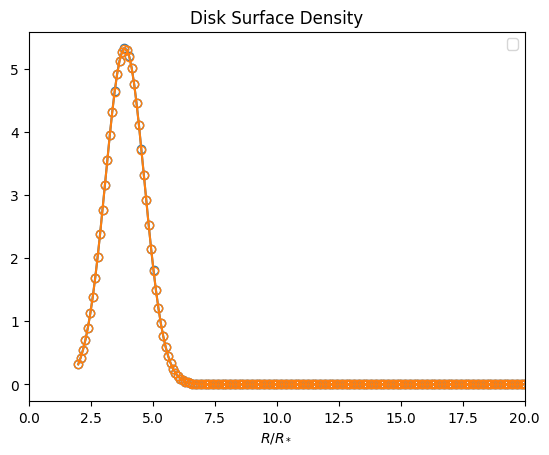

In [167]:
GM = 1.0
Mdot = 1.0
Rstar = 1.0


def kinematic_viscosity(R):
    return 1e-1


def kinematic_viscosity_derivative(R):
    return 0.0


def keplerian_omega_log_derivative(R):
    """
    Return the shear profile d(Omega) / d(log R)
    """
    return -1.5 * sqrt(GM / R**3)


def keplerian_omega(R):
    return sqrt(GM / R**3)


def specific_angular_momentum(R):
    return sqrt(GM * R)


def specific_angular_momentum_derivative(R):
    return 0.5 * sqrt(GM / R)


def sigma(M, R):
    """
    Return the surface density
    """
    return M / (pi * diff(R**2))


def radial_velocity(M, R):
    """
    Return the radial gas velocity at the internal zone interfaces

    v = d/dR(R g) / (sigma R l')
    """
    Rc = 0.5 * (R[1:] + R[:-1])
    s = sigma(M, R)
    n = kinematic_viscosity(Rc)
    A = keplerian_omega_log_derivative(Rc)
    g = Rc * s * n * A
    m = specific_angular_momentum_derivative(R[1:-1])
    return diff(Rc * g) / diff(Rc) / (0.5 * (s[1:] + s[:-1]) * m * R[1:-1])


def sigma2(M, R, t):
    """
    Return the analytic solution for the surface density
    """
    #R0 = R[:-1]
    #R1 = R[+1:]
    #Rc = 0.5 * (R1 + R0)
    m = 1.0
    t = 1.0
    #Ri = 2.5
    Ri = 4.0
    n = kinematic_viscosity(R)
    tau = 12 * n * (Ri**-2) * t
    x = (R/Ri)
    return ((m/pi * Ri**2) * tau**(-1) * (x**(-1/4)) * exp(-(1+(x**2))/tau) * scipy.special.iv(0.25, 2 * x / tau))


def godunov_fluxes(M, R, ret_torque=False):
    R0 = R[:-1]
    R1 = R[+1:]

    Fhat = zeros_like(R)
    s = sigma(M, R)
    v_hat = radial_velocity(M, R)
    s_hat = (v_hat > 0.0) * s[:-1] + (v_hat < 0.0) * s[1:]
    Fhat[1:-1] = 2 * pi * R[1:-1] * s_hat * v_hat

    # Boundary conditions on the mass flux:
    Fhat[+0] = -Mdot
    Fhat[-1] = -Mdot

    if ret_torque:
        A = keplerian_omega_log_derivative(R)
        nu = kinematic_viscosity(R)
        Ghat = zeros_like(R)
        Ghat[1:-1] = -2 * pi * s_hat * (nu * A * R**2)[1:-1]
        return Fhat, Fhat * specific_angular_momentum(R), Ghat
    else:
        return Fhat


def time_derivative(M, R):
    Fhat = godunov_fluxes(M, R)
    return -diff(Fhat)


def plot(M, R, ax=None):
    from matplotlib import pyplot as plt

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    R0 = R[:-1]
    R1 = R[+1:]
    Rc = 0.5 * (R0 + R1)
    mdot, Jdot_adv, Jdot_vis = godunov_fluxes(M, R, ret_torque=True)
    v = radial_velocity(M, R)
    ax.set_xlabel(r"$R / R_*$")
    # ax.set(xlim = (70, 100))
    ax.legend()
    return ax


def main():
    N = 1000
    R = linspace(2.0 * Rstar, 100.0 * Rstar, N + 1)
    dR = diff(R)
    R0 = R[:-1]
    R1 = R[+1:]
    Rc = 0.5 * (R0 + R1)
    dt = 0.1 * (dR**2 / kinematic_viscosity(R)).min()

    # initial condition for a constant-nu disk:
    #nu = kinematic_viscosity(0.0)
    #s = Mdot / (3 * pi * nu) * (1 - sqrt(Rstar / Rc)) + 0.5 * exp(
    #    -((Rc - 20.0) ** 2) / 20.0
    #)

    t = 0.01
    tinitial = 0.01
    tfinal = 10.0

    s = 1.0
    M = s * pi * (R1**2 - R0**2)
    n = 0

    fig = plt.figure()
    ax = fig.add_subplot(111)

    if plot:
        plot(M, R, ax=ax)
    s1 = sigma2(M, R, tinitial)
    s2 = sigma2(M, R, tfinal)/1.001
    ax.plot(R, s1, "-o", mfc="none", label=r"$\Sigma$ Numerical")
    ax.plot(R, s2, "-o", mfc="none", label=r"$\Sigma$ Analytic")

    while t < tfinal:
        K = time_derivative(M, R)
        M += K * dt
        t += dt
        n += 1
        #print(f"[{n:04d}] t={t:04f}")

    if plot:
        # plot(M, R, ax=ax)
        plt.title('Disk Surface Density')
        plt.xlim([0, 20])
        plt.show()

main()

The mass dissipation rate of the disk will then be calcualted under the assumption of a steady disk. This rate is based on the kinematic viscosity, disk surface density, and the circular keplarian acceleration. Directly from this, the luminosity of the steady disk will be calculated by integrating the dissipation rate over the disk from the center to infinity. In the next cell, I plot luminosity vs. frequency on a logarithmic scale.

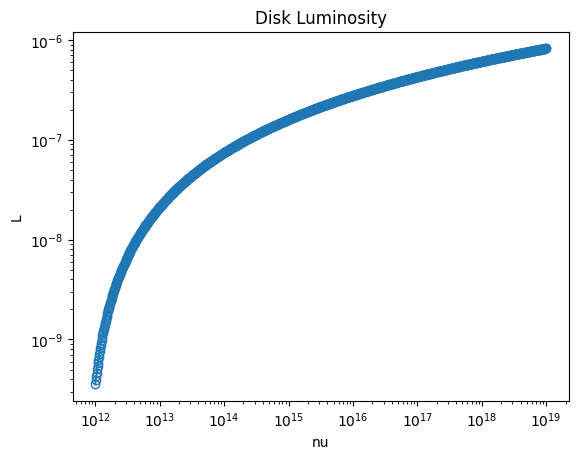

In [166]:
tinitial = 1.0
N = 1000
R = np.linspace(2.0 * Rstar, 100.0 * Rstar, N + 1)
dR = diff(R)
R0 = R[:-1]
R1 = R[+1:]
Rc = 0.5 * (R0 + R1)
dt = 0.1 * (dR**2 / kinematic_viscosity(R)).min()
s = 1.0
M = s * pi * (R1**2 - R0**2)
s1 = sigma2(M, R, tinitial)
G = 10**-11
nu_v = logspace(12, 19, 999)

#Vr = radial_velocity(M, R)
# for R >> Rstar,
Vr = -3 * kinematic_viscosity(R) / (2 * R)

#Mdot = 2 * np.pi * R * np.dot(s1[:-2], -Vr)
# for R >> Rstar,
Mdot = 2 * np.pi * R * np.dot(s1, -Vr)
#Mdot = 1.0

L = 0.5 * G * M * Mdot[+1:] / Rstar   #Mdot[:-1]

plt.plot(nu_v, L[:-1], "-o", mfc="none")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('nu')
plt.ylabel('L')
plt.title('Disk Luminosity')
plt.show()

The next cell begins calculations for the thermal spectrum of the disk, assuming it is an isothermal blackbody; optically thick. A disk temperature profile is derived from these conditions, and from this the spectrum emitted will be calcualted and plotted here.

In [163]:
def disk_temperature(R: float, R0: float, M: float, Mdot: float):
    """
    The surface temperature of a steady-state disk with inner radius R0
    This is Eqn. 3.23 of Pringle (1981).
    """
    return Tstar(R0, M, Mdot) * ((R0 / R) ** 3 * (1 - sqrt(R0 / R))) ** 0.25


def Tstar(R0: float, M: float, Mdot: float):
    """
    The temperature of the inner edge of a steady-state accretion disk
    This equation appears below Eqn. 3.23 of Pringle (1981); note there is a
    typo in the paper: the R is missing a subscript "star".
    """
    return (3 * G * M * Mdot[:-1] / (8 * np.pi * R0**3 * sb)) ** 0.25


def planck_spectrum(T, nu):
    """
    The specific intensity of a blackbody of temperature T, and frequency nu.
    """
    return 2 * h * nu**3 / c**2 / (exp(h * nu / (k * T)) - 1)


def disk_spectrum(M: float, Mdot: float, R0: float, Rout: float, delta: float = 0.1):
    """
    Produce a disk spectrum
    Uses a 1st-order integral over disk radius to produce the multi-temperature
    BB spectrum of a disk, which extends from R0 to Rout.
    Note: the frequency range is currently hard-coded. This should be fixed so
    that it has a sensible default range of frequencies.
    Note: multiply the result by pi to obtain the isotropic specific power
    Inu = integral of 2 * pi * R * dR * Bnu(T(R), nu) from R0 -> Rout
    """
    nu_v = logspace(12, 19, 999)
    nu_c = 0.5 * (nu_v[1:] + nu_v[:-1])
    R = R0 * 1.0001
    R1 = Rout
    Inu = zeros_like(nu_c)
    dR = R * delta
    Inu += 2 * pi * R * dR * planck_spectrum(disk_temperature(R, R0, M, Mdot), nu_c)
    R *= 1.0 + delta
    return nu_v, Inu
    nu_v, Inu1 = disk_spectrum(M, Mdot, R0, Rout, delta=0.001)
    plt.plot(nu_v, Inu1, "-o", mfc="none")

#disk_spectrum(M, Mdot, R0, R)

To represent how the spectrum evolves over time, I will next plot the spectrum at key times during the spreading of the gaseous annulus overlayed by varying the time parameter of the disk's surface density. I'm considering adding a widget on a seperate spectrum plot as well to vary the time.